### Yevonnael Andrew
#### Linear Regression Personal Project

# Introduction

## Problem Statement

A Chinese automobile company Geely Auto aspires to enter the US market by setting up their manufacturing unit and producing cars locally to give competition to their US and European counterparts. 

They have contracted an automobile consulting company to understand the factors on which the pricing of cars depends. Specifically, they want to understand the factors affecting the pricing of cars in the American market, since those may differ from the Chinese market. The company wants to know:

- Which variables are significant in predicting the price of a car
- How well those variables describe the price of a car

Based on various market surveys, the consulting firm has gathered a large dataset of different types of cars across the American market. 

## Business Goals

We will model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy, etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market. 

## Model Evaluation

When we're done with model building and residual analysis and have made predictions on the test set, We will calculate the r-squared on the test set to compare the models' performance.

# Data Understanding

In [1]:
# Import all packages needed for analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings; warnings.filterwarnings('ignore')

In [2]:
# Read the given CSV file, and view some sample records
df = pd.read_csv("CarPrice_Assignment.csv")
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


There is a variable named **CarName**, which comprises two parts - the first word is the name of 'car company', and the second is the 'car model'. For example, 'alfa-romero giulia' has 'alfa-romero' as the car company name and 'giulia' as the car model. 

We will extract the car company name and assign it to a new variable: **brand**.

In [3]:
# Extracting car's brand
df['brand'] = pd.DataFrame(df.CarName.str.split(' ').tolist())[0]

In [4]:
# Check the unique value of the car's brand
df.brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

There are some typo in the car's brand name. We will fix it first.

In [5]:
# Replacing the typo values with the correct one
df['brand'] = df['brand'].replace(['maxda'], 'mazda')
df['brand'] = df['brand'].replace(['Nissan'], 'nissan')
df['brand'] = df['brand'].replace(['toyouta'], 'toyota')
df['brand'] = df['brand'].replace(['porcshce'], 'porsche')
df['brand'] = df['brand'].replace(['vokswagen', 'volkswagen'], 'vw')

### Calculate Null Values

In [6]:
df.isnull().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
brand               0
dtype: int64

### Drop Unused Columns

In [7]:
df = df.drop(['car_ID','CarName'], axis=1)

In [8]:
# To ensure the columns are dropped
df.columns

Index(['symboling', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'wheelbase', 'carlength', 'carwidth',
       'carheight', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize',
       'fuelsystem', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'price', 'brand'],
      dtype='object')

## EDA: Univariate Analysis

First of all, we will be doing a univariate analysis. Univariate analysis is a type of analysis which is using only one variable.

### Car Brand

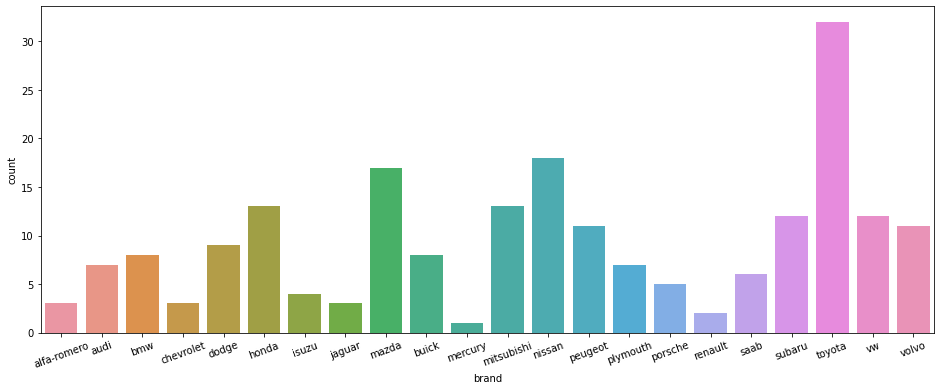

In [9]:
plt.figure(figsize= [16,6])
plt.xticks(rotation = 20)
sns.countplot(df.brand); plt.show()

### Price

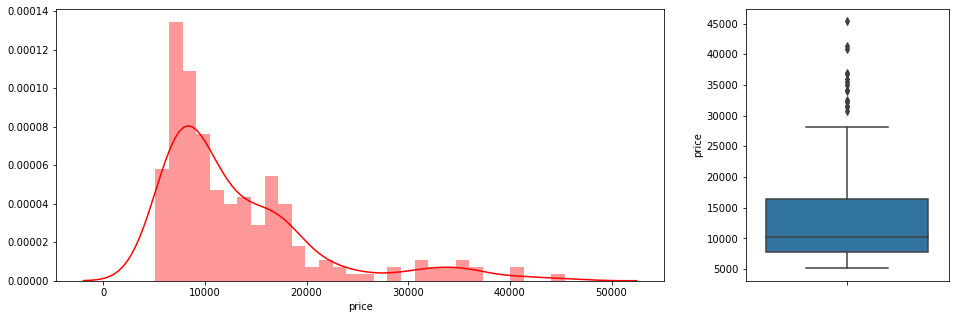

In [10]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
sns.distplot(df.price, bins = 30, color = 'r')
ax1 = plt.subplot(gs[1])
sns.boxplot(df.price, orient = 'v')
plt.show()

We could see here that the median price of the car roughly 10000.

### Bivariate Analysis

We will now see the correlation of the numerical variables in the heatmap forms. We will annotate each with a number so we can see the correlation between the variables.

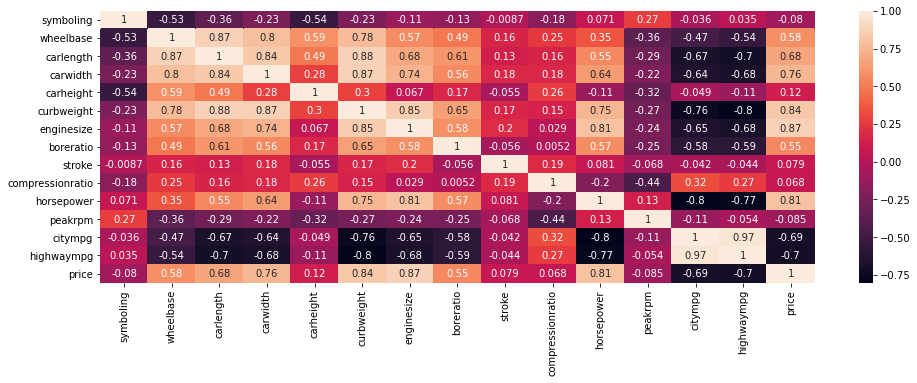

In [11]:
plt.figure(figsize= [16,5])
sns.heatmap(df.corr(), annot = True);

We want to know what affect prices, by looking at the heatmap, some candidates are:
- citympg 
- highwaympg 
- horsepower 
- boreratio 
- enginesize 
- curbweight
- carwidth
- carlength 
- wheelbase

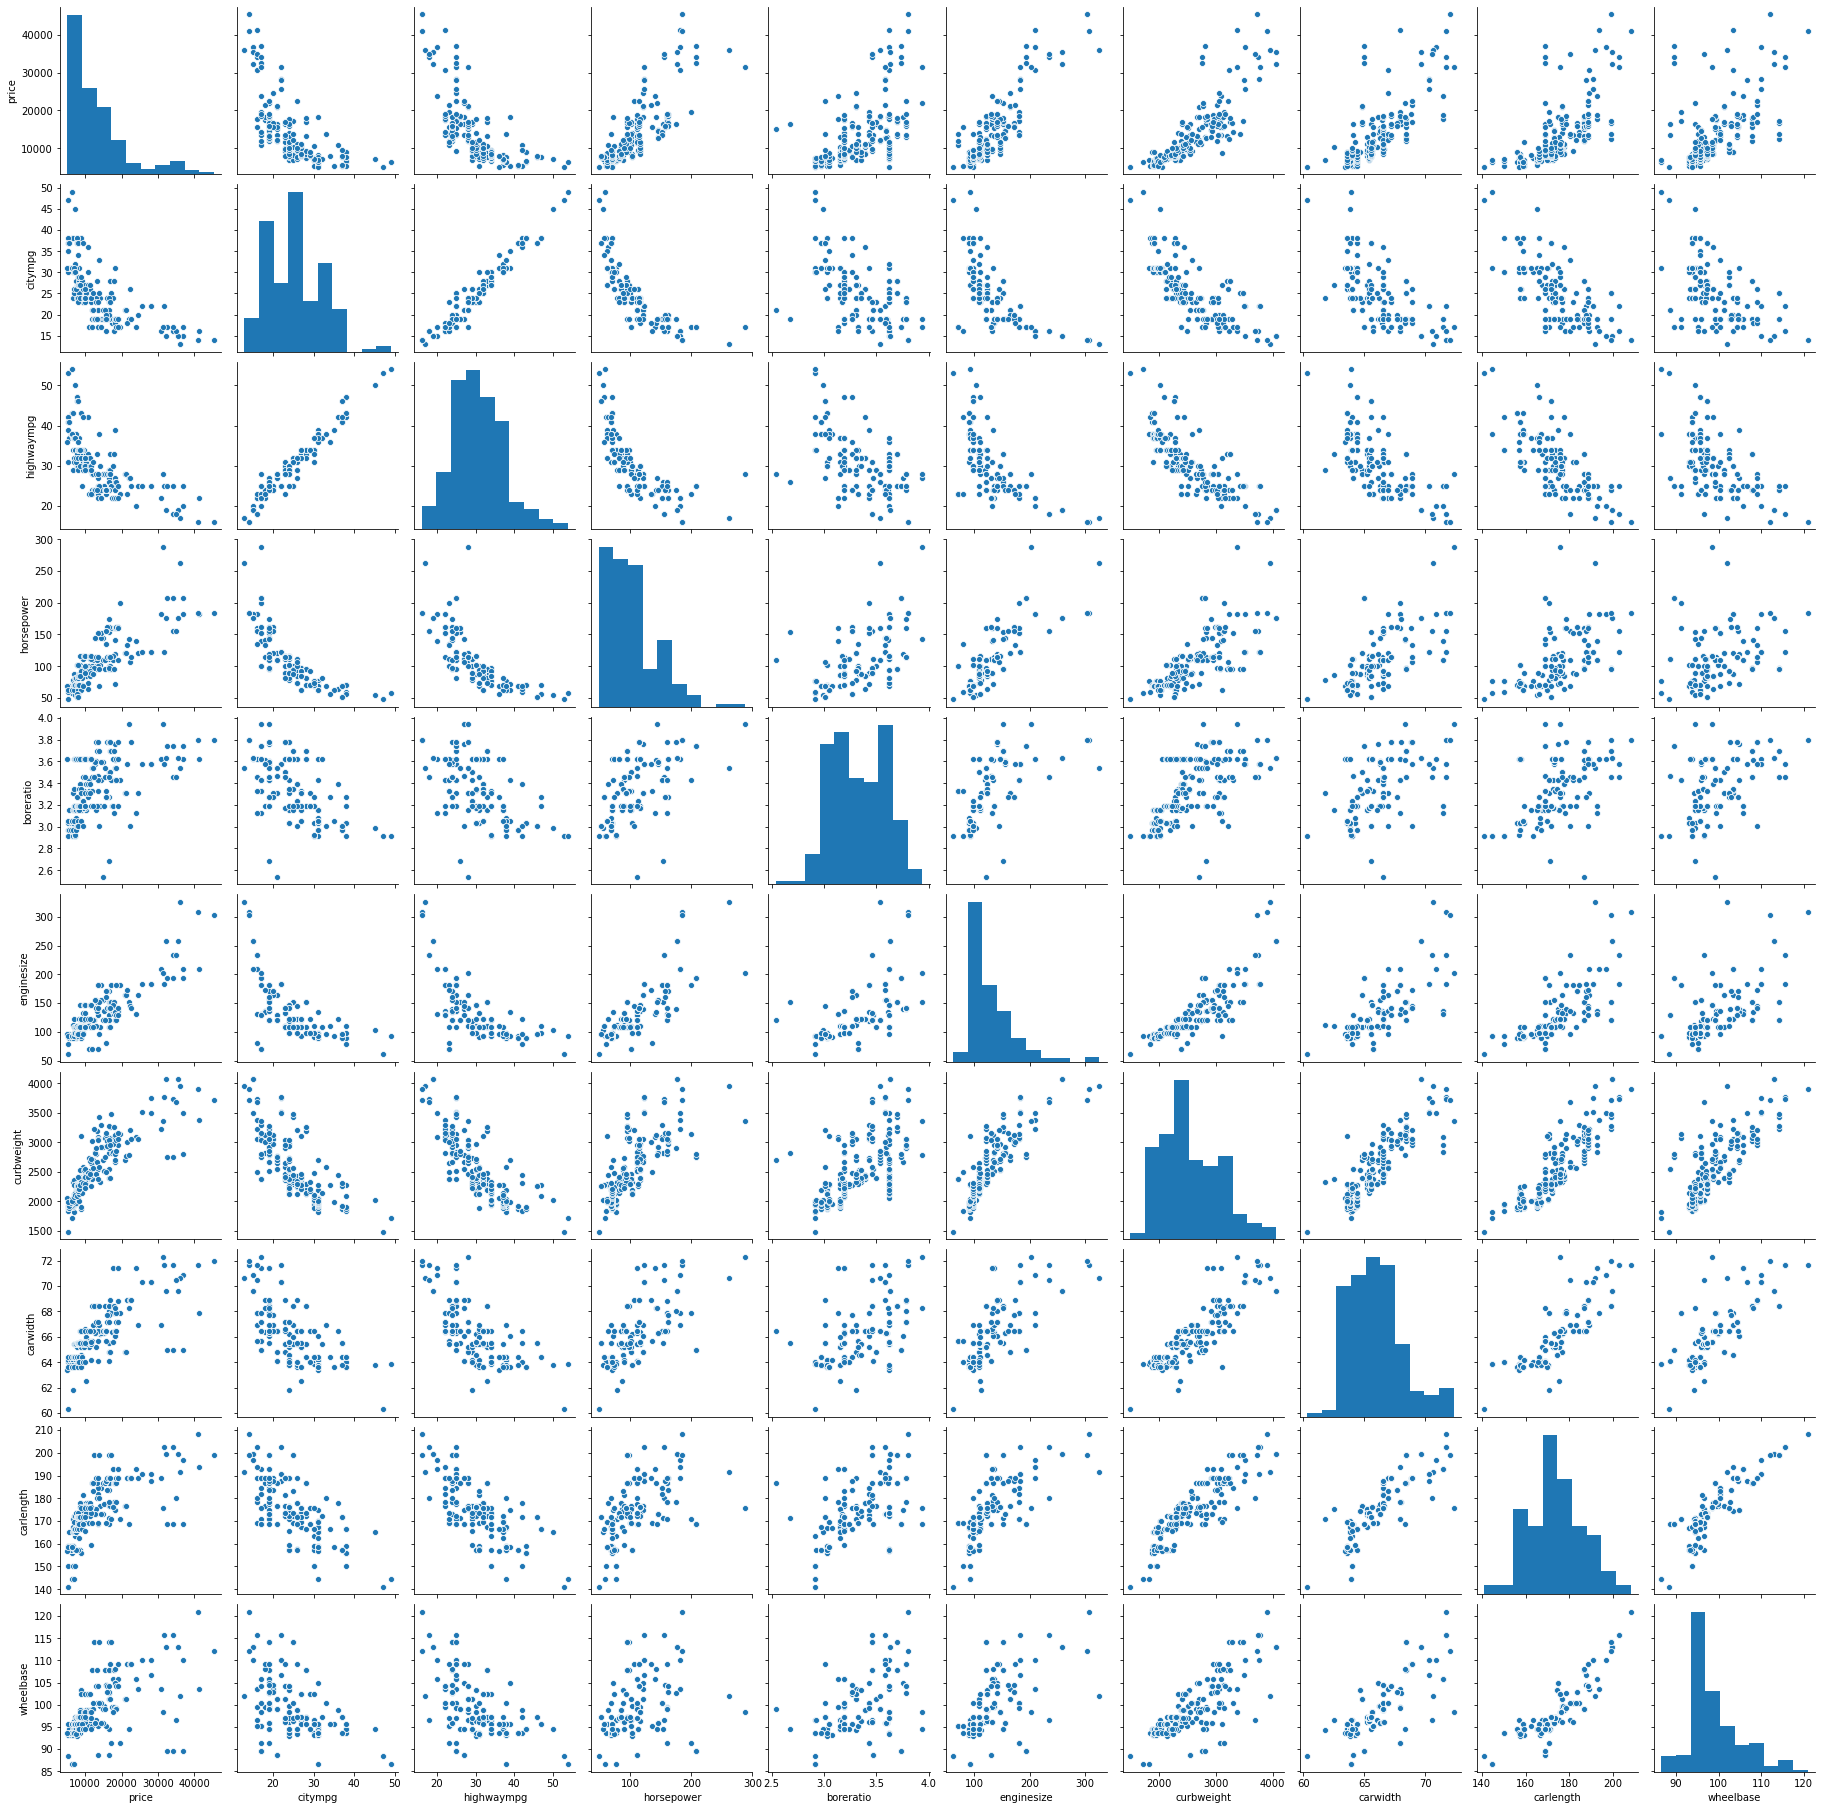

In [12]:
sns.pairplot(df, vars = ['price', 'citympg', 'highwaympg', 'horsepower', 'boreratio', 
                         'enginesize', 'curbweight', 'carwidth', 'carlength', 'wheelbase']);

From the pairplot something we can notice:
- highwaympg and citympg are highly correlated
- We suspect there are a lot of multicolinearity between the numeric variables

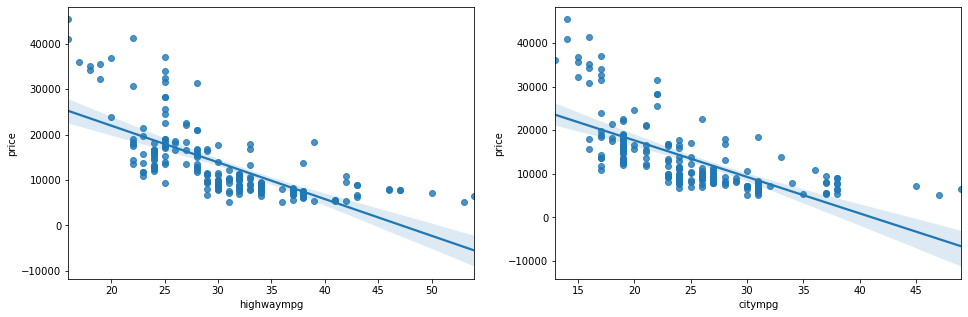

In [13]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.regplot(x = 'highwaympg', y = 'price', data = df)
ax1 = plt.subplot(gs[1])
sns.regplot(x = 'citympg', y = 'price', data = df)
plt.show()

Here we could visually notice that there is a strong correlation between highwaympg and citympg and both of them correlate with price.

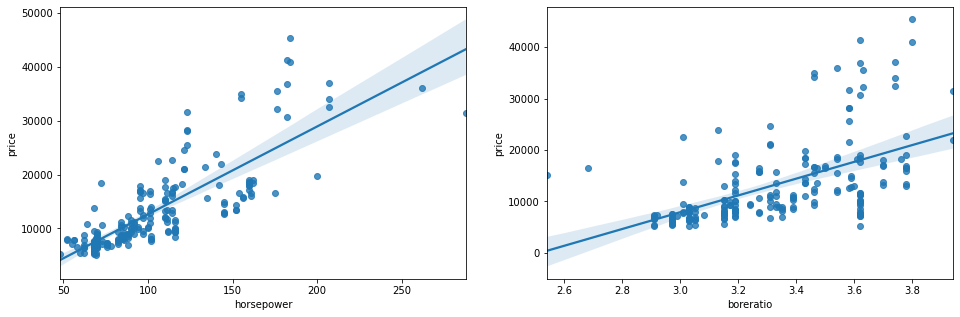

In [14]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.regplot(x = 'horsepower', y = 'price', data = df)
ax1 = plt.subplot(gs[1])
sns.regplot(x = 'boreratio', y = 'price', data = df)
plt.show()

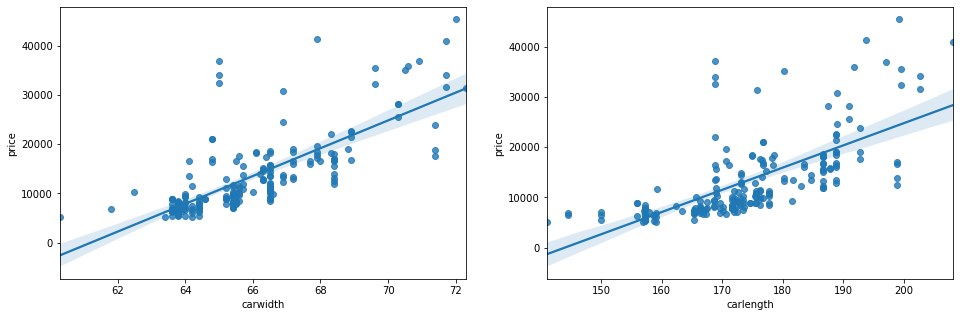

In [15]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.regplot(x = 'carwidth', y = 'price', data = df)
ax1 = plt.subplot(gs[1])
sns.regplot(x = 'carlength', y = 'price', data = df)
plt.show()

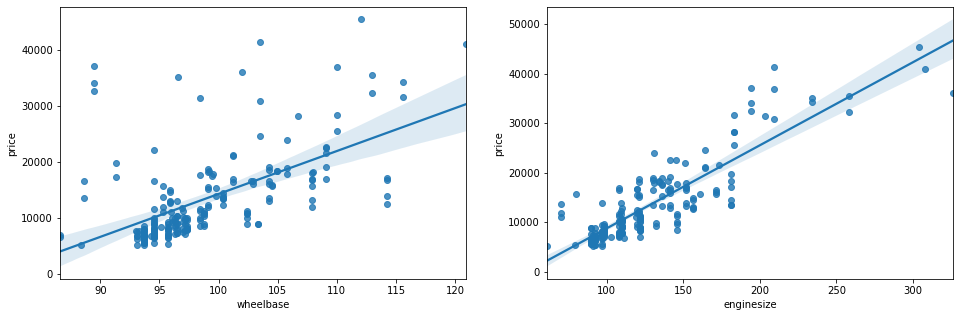

In [16]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.regplot(x = 'wheelbase', y = 'price', data = df)
ax1 = plt.subplot(gs[1])
sns.regplot(x = 'enginesize', y = 'price', data = df)
plt.show()

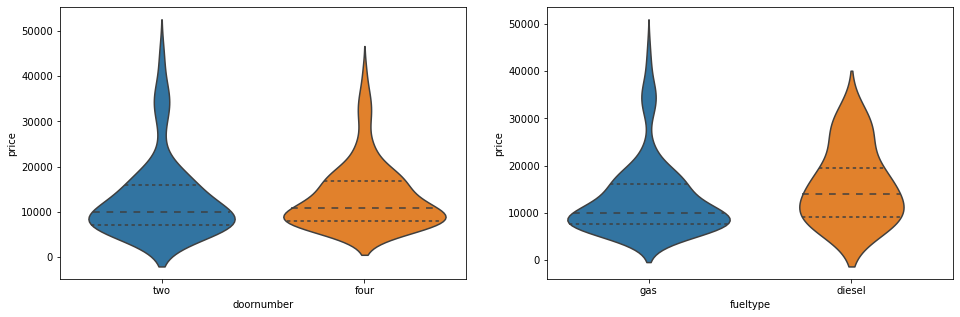

In [17]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.violinplot(x = 'doornumber', y = 'price', data = df, inner="quartile")
ax1 = plt.subplot(gs[1])
sns.violinplot(x = 'fueltype', y = 'price', data = df, inner="quartile")
plt.show()

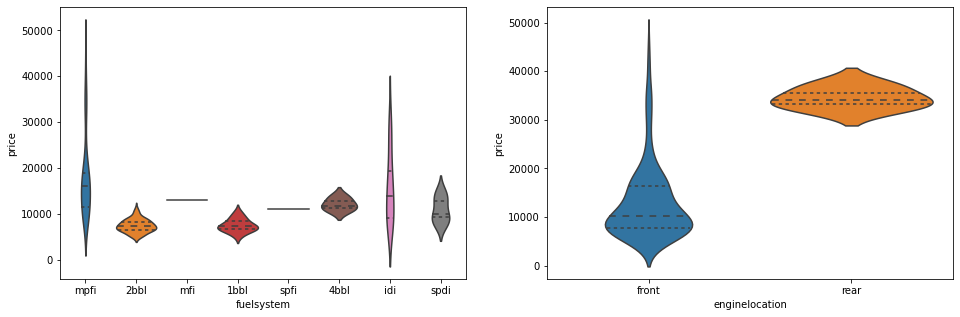

In [18]:
plt.figure(figsize= [16,5])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
sns.violinplot(x = 'fuelsystem', y = 'price', data = df, inner="quartile")
ax1 = plt.subplot(gs[1])
sns.violinplot(x = 'enginelocation', y = 'price', data = df, inner="quartile")
plt.show()

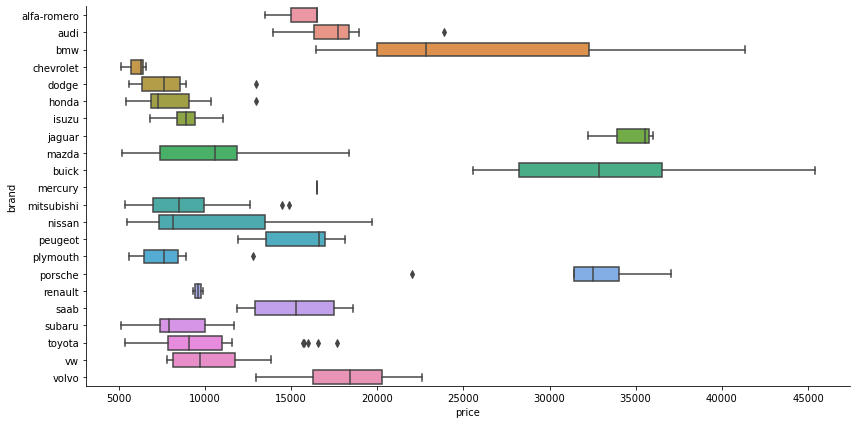

In [19]:
sns.catplot(y="brand", x="price", kind="box", data=df, height=6, aspect=2)
plt.show()

## Feature Engineering
### Segmentation by Price Level

In [20]:
# Creating a new categorical columns
df['brand_cat'] = np.nan; lst = [df]

for x in lst:
    x.loc[x['price'] <= 10000, 'brand_cat'] = 'Mainstream'
    x.loc[(x['price'] > 10000) & (x['price'] <= 20000), 'brand_cat'] = 'Upscale_Mainstream'
    x.loc[x['price'] > 20000, 'brand_cat'] = 'Premium'

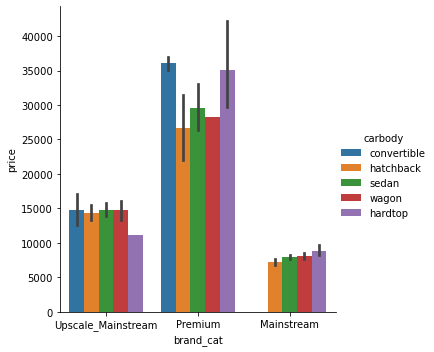

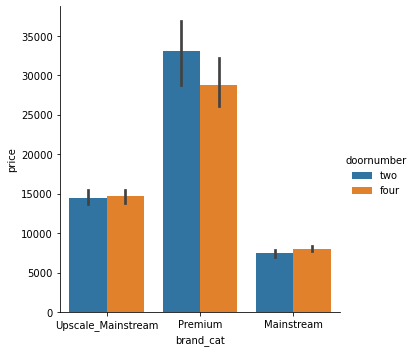

In [21]:
sns.catplot(x="brand_cat", y="price", hue="carbody", data=df, kind="bar");
sns.catplot(x="brand_cat", y="price", hue="doornumber", data=df, kind="bar");

In the premium segmentation, the car with doornumber two costs more. The body type of hardtop and convertible are also cost more.

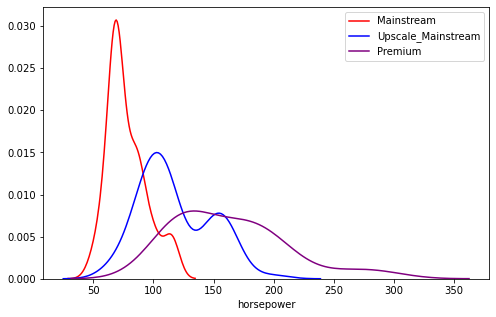

In [22]:
plt.figure(figsize= [8,5])
sns.distplot(df[df.brand_cat == 'Mainstream']['horsepower'], hist = False, color = 'red', label = 'Mainstream');
sns.distplot(df[df.brand_cat == 'Upscale_Mainstream']['horsepower'], hist = False, color = 'blue', label = 'Upscale_Mainstream');
sns.distplot(df[df.brand_cat == 'Premium']['horsepower'], hist = False, color = 'purple', label = 'Premium');

Here we see a clear distinction of horsepower and segmentation. Premium segmentation is dominated by higher horsepower than the mainstream one. 

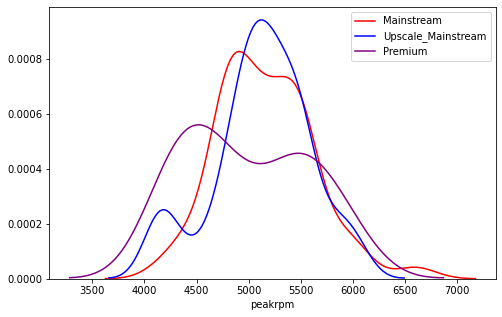

In [23]:
plt.figure(figsize= [8,5])
sns.distplot(df[df.brand_cat == 'Mainstream']['peakrpm'], hist = False, color = 'red', label = 'Mainstream');
sns.distplot(df[df.brand_cat == 'Upscale_Mainstream']['peakrpm'], hist = False, color = 'blue', label = 'Upscale_Mainstream');
sns.distplot(df[df.brand_cat == 'Premium']['peakrpm'], hist = False, color = 'purple', label = 'Premium');

### Segmentation by Brand's Origin

We know intuitively that a European car usually costs more than an Asian car. Let's explore that in this section

In [24]:
# Define the function of the car's brand origin
def origin(row):
    if row['brand'] == 'alfa-romero' or row['brand'] == 'audi' or row['brand'] == 'bmw' or row['brand'] == 'jaguar' or row['brand'] == 'peugeot' or row['brand'] == 'porsche' or row['brand'] == 'renault' or row['brand'] == 'saab' or row['brand'] == 'vw' or row['brand'] == 'volvo':
        val = "European"
    elif row['brand'] == 'chevrolet' or row['brand'] == 'dodge' or row['brand'] == 'buick' or row['brand'] == 'mercury' or row['brand'] == 'plymouth':
        val = "American"
    elif row['brand'] == 'honda' or row['brand'] == 'isuzu' or row['brand'] == 'mazda' or row['brand'] == 'mitsubishi' or row['brand'] == 'nissan' or row['brand'] == 'subaru' or row['brand'] == 'toyota':
        val = "Asian"
    return val

In [25]:
# Applying the function
df['brand_origin'] = df.apply(origin, axis = 1)

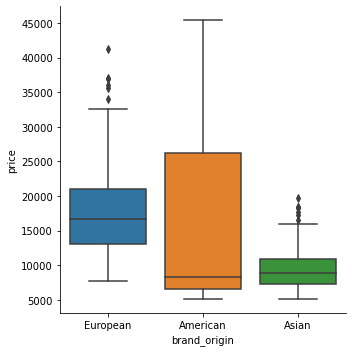

In [26]:
sns.catplot(x="brand_origin", y="price", data=df, kind="box");

In general Asian car is more cheaper than the European car.

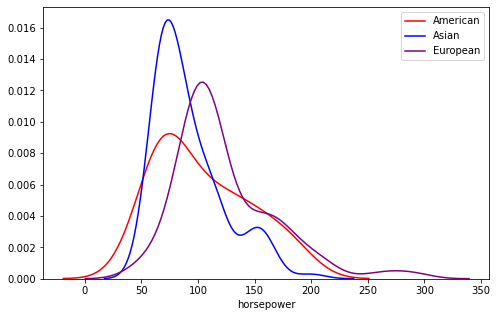

In [27]:
plt.figure(figsize= [8,5])
sns.distplot(df[df.brand_origin == 'American']['horsepower'], hist = False, color = 'red', label = 'American');
sns.distplot(df[df.brand_origin == 'Asian']['horsepower'], hist = False, color = 'blue', label = 'Asian');
sns.distplot(df[df.brand_origin == 'European']['horsepower'], hist = False, color = 'purple', label = 'European');

In average, European car has higher horsepower and Asian car has thinner tail in right the right side of the graph.

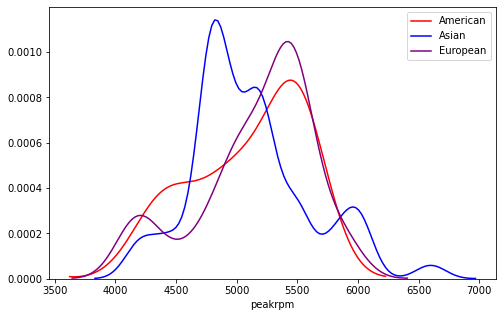

In [28]:
plt.figure(figsize= [8,5])
sns.distplot(df[df.brand_origin == 'American']['peakrpm'], hist = False, color = 'red', label = 'American');
sns.distplot(df[df.brand_origin == 'Asian']['peakrpm'], hist = False, color = 'blue', label = 'Asian');
sns.distplot(df[df.brand_origin == 'European']['peakrpm'], hist = False, color = 'purple', label = 'European');

We could also notice that Asian car has lower peakrpm than other car.

## Cost per Horsepower and Peak RPM?

In [29]:
# cost per horsepower
df['cost_per_horsepower'] = df['price']/df['horsepower']
# cost per peak rpm
df['cost_per_peakrpm'] = df['price']/df['peakrpm']

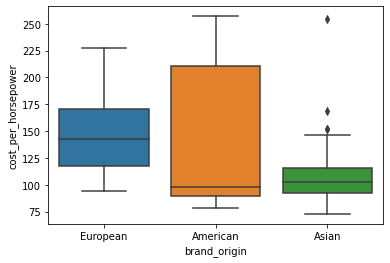

In [30]:
sns.boxplot(x='brand_origin', y='cost_per_horsepower', data=df);

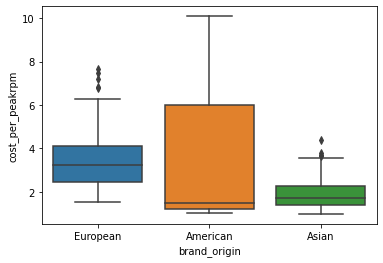

In [31]:
sns.boxplot(x='brand_origin', y='cost_per_peakrpm', data=df);

From above, we could see several interesting things:
1. In general, Asian cars cost less each peak rpm and each horsepower compared to a European car.
2. American car has a vast range in terms of cost_per_peakrpm and cost_per_horsepower.

## Preliminary Modelling

From domain expertise, we are sure that the price of the cars is affected by its horsepower.
Now, we will try:

**First Model: lm_1 = Single linear regression by only using horsepower.**

For the whole analysis, we will use the 70%-30% ratio for splitting the data into train and test set.

In [32]:
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 29)
(62, 29)


In [33]:
y_train = df_train['price']
X_train = df_train['horsepower']
X_train = sm.add_constant(X_train)
lm_1 = sm.OLS(y_train, X_train).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     261.8
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           6.04e-34
Time:                        21:02:45   Log-Likelihood:                -1409.0
No. Observations:                 143   AIC:                             2822.
Df Residuals:                     141   BIC:                             2828.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3192.6506   1076.508     -2.966      0.0

In [34]:
r2_score(df_test['price'], lm_1.predict(sm.add_constant(df_test['horsepower'])))

0.6558067492898347

**Second Model: lm_2 = Horsepower and Peak RPM.**

In [35]:
y_train = df_train['price']
X_train = df_train[['horsepower','peakrpm']]
X_train = sm.add_constant(X_train)
lm_2 = sm.OLS(y_train, X_train).fit()
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     161.5
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           4.39e-37
Time:                        21:02:45   Log-Likelihood:                -1398.6
No. Observations:                 143   AIC:                             2803.
Df Residuals:                     140   BIC:                             2812.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.459e+04   3917.988      3.725      0.0

**Third Model: lm_3 = Horsepower, Peak RPM, highwaympg.**

In [36]:
y_train = df_train['price']
X_train = df_train[['horsepower','peakrpm','highwaympg']]
X_train = sm.add_constant(X_train)
lm_3 = sm.OLS(y_train, X_train).fit()
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     114.5
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.15e-37
Time:                        21:02:46   Log-Likelihood:                -1395.1
No. Observations:                 143   AIC:                             2798.
Df Residuals:                     139   BIC:                             2810.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.337e+04   5079.432      4.601      0.0

**Fourth Model: lm_4 = Horsepower, Peak RPM, highwaympg, curbweight**

In [37]:
y_train = df_train['price']
X_train = df_train[['horsepower','peakrpm','highwaympg', 'curbweight']]
X_train = sm.add_constant(X_train)
lm_4 = sm.OLS(y_train, X_train).fit()
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     140.1
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.44e-47
Time:                        21:02:46   Log-Likelihood:                -1368.1
No. Observations:                 143   AIC:                             2746.
Df Residuals:                     138   BIC:                             2761.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.656e+04   7570.045     -3.509      0.0

## Modelling with Categorical Variables

From previous EDA, we could see that brand origin certainly has a strong correlation with price. We will add this variable in this modeling section.

In [38]:
# Let's drop the first column from status df using 'drop_first = True'
brand_origin = pd.get_dummies(df['brand_origin'], drop_first = True)
# Add the results to the original housing dataframe
df = pd.concat([df, brand_origin], axis = 1)
# Split to train and test
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 31)
(62, 31)


In [39]:
y_train = df_train['price']
X_train = df_train[list(brand_origin) + ['horsepower','peakrpm','highwaympg', 'curbweight']]
X_train = sm.add_constant(X_train)
lm_5 = sm.OLS(y_train, X_train).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     105.7
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.02e-48
Time:                        21:02:46   Log-Likelihood:                -1360.1
No. Observations:                 143   AIC:                             2734.
Df Residuals:                     136   BIC:                             2755.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.548e+04   7757.393     -1.996      0.0

### How about Carbody? Sedan or mpv car must be different right?

In [40]:
# Let's drop the first column from status df using 'drop_first = True'
carbody = pd.get_dummies(df['carbody'], drop_first = True)
# Add the results to the original housing dataframe
df = pd.concat([df, carbody], axis = 1)
# Split to train and test
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 35)
(62, 35)


In [41]:
y_train = df_train['price']
X_train = df_train[list(carbody) + list(brand_origin) + ['horsepower','peakrpm','highwaympg', 'curbweight']]
X_train = sm.add_constant(X_train)
lm_5 = sm.OLS(y_train, X_train).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     71.02
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.56e-48
Time:                        21:02:47   Log-Likelihood:                -1351.6
No. Observations:                 143   AIC:                             2725.
Df Residuals:                     132   BIC:                             2758.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.592e+04   7460.361     -2.133      0.0

### Engine Location?
From EDA, we could see a huge gap in price in terms of engine location. Let's account for that.

In [42]:
# Let's drop the first column from status df using 'drop_first = True'
enginelocation = pd.get_dummies(df['enginelocation'], drop_first = True)
# Add the results to the original housing dataframe
df = pd.concat([df, enginelocation], axis = 1)
# Split to train and test
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 36)
(62, 36)


In [43]:
y_train = df_train['price']
X_train = df_train[list(enginelocation) + list(carbody) + list(brand_origin) + ['horsepower','peakrpm','highwaympg', 'curbweight']]
X_train = sm.add_constant(X_train)
lm_5 = sm.OLS(y_train, X_train).fit()
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     69.96
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.46e-49
Time:                        21:02:47   Log-Likelihood:                -1346.2
No. Observations:                 143   AIC:                             2716.
Df Residuals:                     131   BIC:                             2752.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.6e+04   7214.487     -2.217      0.0

## Feature Selection

We will do an automatic feature selection using RFE.

In [44]:
fueltype = pd.get_dummies(df['fueltype'], drop_first = True)
aspiration = pd.get_dummies(df['aspiration'], drop_first = True)
enginetype = pd.get_dummies(df['enginetype'], drop_first = True)
fuelsystem = pd.get_dummies(df['fuelsystem'], drop_first = True)
drivewheel = pd.get_dummies(df['drivewheel'], drop_first = True)
brand_cat = pd.get_dummies(df['brand_cat'], drop_first = True)
cylindernumber = pd.get_dummies(df['cylindernumber'], drop_first = True)

In [45]:
df = pd.concat([df, fueltype, aspiration, enginetype, fuelsystem, drivewheel, brand_cat, cylindernumber], axis = 1)
# Split to train and test
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(143, 61)
(62, 61)


In [46]:
y_train = df_train['price']
X_train = df_train[list(fueltype) + list(aspiration) + list(enginetype) + list(fuelsystem) + 
                   list(drivewheel) + list(brand_cat) + list(cylindernumber) + 
                   list(enginelocation) + list(carbody) + list(brand_origin) + 
                   ['horsepower','peakrpm','highwaympg', 'curbweight']]
X_train = sm.add_constant(X_train)
lm_6 = sm.OLS(y_train, X_train).fit()
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     74.51
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.03e-60
Time:                        21:02:48   Log-Likelihood:                -1260.9
No. Observations:                 143   AIC:                             2588.
Df Residuals:                     110   BIC:                             2686.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -4525.9567   4271

In [47]:
# Running RFE
lm_6 = LinearRegression()
lm_6.fit(X_train, y_train)
rfe = RFE(lm_6, 10) # running RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('const', False, 26),
 ('gas', False, 18),
 ('turbo', False, 6),
 ('dohcv', True, 1),
 ('l', False, 7),
 ('ohc', False, 8),
 ('ohcf', False, 9),
 ('ohcv', False, 4),
 ('rotor', True, 1),
 ('2bbl', False, 11),
 ('4bbl', False, 2),
 ('idi', False, 20),
 ('mfi', False, 28),
 ('mpfi', False, 21),
 ('spdi', False, 14),
 ('spfi', False, 27),
 ('fwd', False, 10),
 ('rwd', False, 3),
 ('Premium', True, 1),
 ('Upscale_Mainstream', True, 1),
 ('five', True, 1),
 ('four', True, 1),
 ('six', True, 1),
 ('three', True, 1),
 ('twelve', False, 15),
 ('two', True, 1),
 ('rear', True, 1),
 ('hardtop', False, 16),
 ('hatchback', False, 17),
 ('sedan', False, 12),
 ('wagon', False, 13),
 ('Asian', False, 19),
 ('European', False, 5),
 ('horsepower', False, 22),
 ('peakrpm', False, 25),
 ('highwaympg', False, 23),
 ('curbweight', False, 24)]

In [48]:
X_train.columns[~rfe.support_]

Index(['const', 'gas', 'turbo', 'l', 'ohc', 'ohcf', 'ohcv', '2bbl', '4bbl',
       'idi', 'mfi', 'mpfi', 'spdi', 'spfi', 'fwd', 'rwd', 'twelve', 'hardtop',
       'hatchback', 'sedan', 'wagon', 'Asian', 'European', 'horsepower',
       'peakrpm', 'highwaympg', 'curbweight'],
      dtype='object')

In [49]:
col = X_train.columns[rfe.support_]; col

Index(['dohcv', 'rotor', 'Premium', 'Upscale_Mainstream', 'five', 'four',
       'six', 'three', 'two', 'rear'],
      dtype='object')

### Building model from RFE

In [50]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [51]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [52]:
lm_rfe = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model

In [53]:
#Let's see the summary of our linear model
print(lm_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     112.4
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.03e-57
Time:                        21:02:49   Log-Likelihood:                -1330.2
No. Observations:                 143   AIC:                             2680.
Df Residuals:                     133   BIC:                             2710.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.796e+04   1903

### VIF Selection
After RFE automatic selection, we will do a VIF analysis.

In [54]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); print(vif)

             Features   VIF
1               rotor   inf
8                 two   inf
3  Upscale_Mainstream  2.07
2             Premium  2.03
6                 six  1.96
5                four  1.47
4                five  1.40
0               dohcv  1.10
9                rear  1.08
7               three  1.00


Infinite VIF means a perfect correlation exists between those variables. From our previous analysis, we found that several variables have infinite VIF (perfect correlation: **rotor, two**. 

We will try to understand what is the definition and the meaning of that. We are incorporating domain knowledge into this analysis.

By reading the data dictionary, we know that:
- two: 2-cylinder engine
- rotor: rotor engine (Wankel engine), a type of internal combustion engine.

From domain knowledge, I suspect that **rotor** is very correlated to a particular brand in the car industry. Let us see the data for the **rotor** engine type.

In [55]:
df[df.enginetype == "rotor"].iloc[:,:27].T

,55,56,57,58
symboling,3,3,3,3
fueltype,gas,gas,gas,gas
aspiration,std,std,std,std
doornumber,two,two,two,two
carbody,hatchback,hatchback,hatchback,hatchback
drivewheel,rwd,rwd,rwd,rwd
enginelocation,front,front,front,front
wheelbase,95.3,95.3,95.3,95.3
carlength,169,169,169,169
carwidth,65.7,65.7,65.7,65.7


Wow, by subsetting the data for **rotor** engine type, we confirm my suspicion that all **rotor** engine is the Mazda brand! We could also see all this car has the same characteristics: they have the same cylinder number, the same fuel type, etc. So it is perfect sense to remove **rotor** variables. 

In [56]:
X_train_rfe = X_train_rfe.drop("rotor", axis = 1)
lm_rfe_2 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     112.4
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.03e-57
Time:                        21:02:50   Log-Likelihood:                -1330.2
No. Observations:                 143   AIC:                             2680.
Df Residuals:                     133   BIC:                             2710.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.796e+04   1903

In [57]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
2,Upscale_Mainstream,2.07
1,Premium,2.03
5,six,1.96
4,four,1.47
3,five,1.40
7,two,1.16
0,dohcv,1.10
8,rear,1.08
6,three,1.00


Now we will try to remove a variable with the highest p-value: **dohcv**

In [58]:
X_train_rfe = X_train_rfe.drop("dohcv", axis = 1)

In [59]:
lm_rfe_3 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     126.0
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.72e-58
Time:                        21:02:50   Log-Likelihood:                -1330.9
No. Observations:                 143   AIC:                             2680.
Df Residuals:                     134   BIC:                             2706.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.704e+04   1731

In [60]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
1,Upscale_Mainstream,2.04
4,six,1.89
0,Premium,1.84
3,four,1.46
2,five,1.37
6,two,1.16
7,rear,1.08
5,three,1.00


## Prediction

In [61]:
df_test = sm.add_constant(df_test)
X_test = df_test[list(X_train_rfe)]
y_test = df_test['price']

In [62]:
y_test_pred = lm_rfe_3.predict(X_test)

#### Testing the Normality Assumption

One assumption in linear regression is that the residuals are normally distributed. Now we will plot the error terms to visualize the distribution of the error.

Text(0.5, 0, 'Errors')

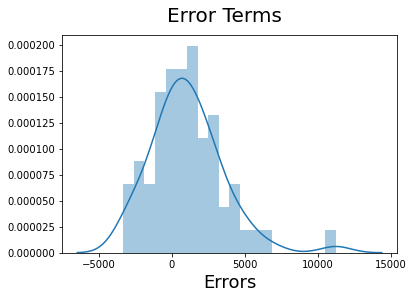

In [63]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_test_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

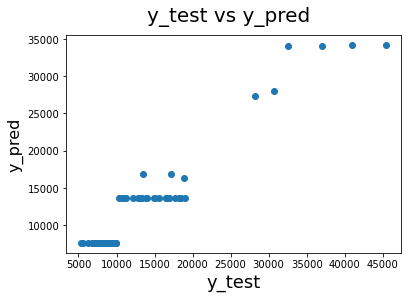

In [64]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [65]:
r2_score(y_test, y_test_pred)

0.893635086503616

R-squared is a statistical measure that represents the proportion of the variance for a dependent variable that’s explained by an independent variable or variables in a regression model. It means that by using automatic RFE with non-normalized variables, we can explain 89% of car price variances.

# Rescaling the Features

The previous section is using the non-normalized variables. In this section, I will do standardization to quantify the differences between non-normalized and the normalized.

In [66]:
scaler = MinMaxScaler()

In [67]:
df = df.drop(list(enginetype), axis = 1)
df = df.drop(['cost_per_horsepower','cost_per_peakrpm','symboling','enginesize'], axis=1)
# Split to train and test
df_train, df_test = train_test_split(df, train_size = 0.7, random_state=100)

In [68]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = list(df.select_dtypes(include=['int64','float64']))
df_train[num_vars] = scaler.fit_transform(df_train[num_vars]) 

In [69]:
y_train = df_train['price']
X_train = df_train[list(fueltype) + list(aspiration) + list(fuelsystem) + 
                   list(cylindernumber) + list(drivewheel) + list(brand_cat) +
                   list(enginelocation) + list(brand_origin) +
                   num_vars]
X_train = sm.add_constant(X_train.drop("price", axis = 1))

In [70]:
# Running RFE
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, 10) # running RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('const', False, 24),
 ('gas', True, 1),
 ('turbo', True, 1),
 ('2bbl', False, 18),
 ('4bbl', False, 12),
 ('idi', True, 1),
 ('mfi', False, 25),
 ('mpfi', False, 17),
 ('spdi', False, 7),
 ('spfi', False, 26),
 ('five', False, 13),
 ('four', False, 14),
 ('six', False, 9),
 ('three', False, 23),
 ('twelve', False, 20),
 ('two', False, 11),
 ('fwd', False, 22),
 ('rwd', False, 21),
 ('Premium', True, 1),
 ('Upscale_Mainstream', False, 2),
 ('rear', True, 1),
 ('Asian', False, 19),
 ('European', False, 16),
 ('wheelbase', False, 10),
 ('carlength', False, 3),
 ('carwidth', False, 8),
 ('carheight', False, 4),
 ('curbweight', True, 1),
 ('boreratio', False, 6),
 ('stroke', False, 5),
 ('compressionratio', True, 1),
 ('horsepower', True, 1),
 ('peakrpm', True, 1),
 ('citympg', True, 1),
 ('highwaympg', False, 15)]

In [71]:
col = X_train.columns[rfe.support_]; col

Index(['gas', 'turbo', 'idi', 'Premium', 'rear', 'curbweight',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg'],
      dtype='object')

In [72]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)
# Running the linear model
lm_rfe = sm.OLS(y_train, X_train_rfe).fit()
#Let's see the summary of our linear model
print(lm_rfe.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     198.7
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.37e-72
Time:                        21:02:53   Log-Likelihood:                 207.88
No. Observations:                 143   AIC:                            -395.8
Df Residuals:                     133   BIC:                            -366.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1442      0.069  

### VIF Selection
After RFE automatic selection, we will do a VIF analysis.

In [73]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
2,idi,114.58
0,gas,83.34
6,compressionratio,68.32
5,curbweight,7.96
9,citympg,4.87
7,horsepower,4.72
1,turbo,2.38
3,Premium,1.88
8,peakrpm,1.73
4,rear,1.19


From the previous analysis, we know that infinite VIF means a perfect correlation.

We find that two variables have a perfect correlation: **idi** and **gas**

From domain knowledge, we know that **idi** is International Harvester IDI, a type of Diesel Engine. So we will remove this variable.

In [74]:
X_train_rfe = X_train_rfe.drop(["idi"], axis = 1)
lm_rfe_2 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     198.7
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           1.37e-72
Time:                        21:02:54   Log-Likelihood:                 207.88
No. Observations:                 143   AIC:                            -395.8
Df Residuals:                     133   BIC:                            -366.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4690      0.174  

In [75]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
0,gas,53.57
4,curbweight,30.70
8,citympg,21.42
5,compressionratio,14.04
6,horsepower,12.52
7,peakrpm,8.96
2,Premium,2.04
1,turbo,1.57
3,rear,1.18


**citympg** are both have high p-value and high VIF.

We will try to remove **citympg** first.

In [76]:
X_train_rfe = X_train_rfe.drop("citympg", axis = 1)
lm_rfe_3 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     224.8
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           9.75e-74
Time:                        21:02:55   Log-Likelihood:                 207.77
No. Observations:                 143   AIC:                            -397.5
Df Residuals:                     134   BIC:                            -370.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.4766      0.173  

In [77]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
4,curbweight,19.68
6,horsepower,12.03
0,gas,11.67
7,peakrpm,8.28
5,compressionratio,2.97
2,Premium,2.03
1,turbo,1.56
3,rear,1.18


We will remove **curbweight** because it has high VIF value.

In [78]:
X_train_rfe = X_train_rfe.drop("curbweight", axis = 1)
lm_rfe_4 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_4.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     185.4
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           5.39e-66
Time:                        21:02:55   Log-Likelihood:                 185.83
No. Observations:                 143   AIC:                            -355.7
Df Residuals:                     135   BIC:                            -332.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0361      0.177  

In [79]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
0,gas,8.15
6,peakrpm,7.24
5,horsepower,5.12
2,Premium,1.94
1,turbo,1.53
4,compressionratio,1.52
3,rear,1.10


We will try to remove the one by one the highest p-value first.

In [80]:
X_train_rfe = X_train_rfe.drop("peakrpm", axis = 1)
lm_rfe_5 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     217.9
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           3.50e-67
Time:                        21:02:55   Log-Likelihood:                 185.83
No. Observations:                 143   AIC:                            -357.7
Df Residuals:                     136   BIC:                            -336.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0338      0.172  

In [81]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
5,horsepower,5.05
0,gas,3.15
2,Premium,1.87
1,turbo,1.53
4,compressionratio,1.47
3,rear,1.08


In [82]:
X_train_rfe = X_train_rfe.drop("rear", axis = 1)
lm_rfe_6 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     263.0
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           2.22e-68
Time:                        21:02:56   Log-Likelihood:                 185.75
No. Observations:                 143   AIC:                            -359.5
Df Residuals:                     137   BIC:                            -341.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.0293      0.171  

In [83]:
X_train_new = X_train_rfe.drop("const", axis = 1)
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False); vif

,Features,VIF
4,horsepower,4.95
0,gas,3.13
2,Premium,1.85
1,turbo,1.51
3,compressionratio,1.47


In [84]:
df_test[num_vars] = scaler.transform(df_test[num_vars])
y_test = df_test.pop('price')
X_test = df_test

In [85]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [86]:
# Making predictions
y_pred = lm_rfe_6.predict(X_test_new)

Text(0.5, 0, 'Errors')

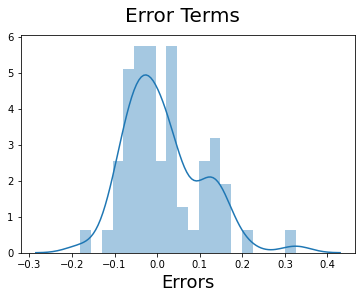

In [87]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

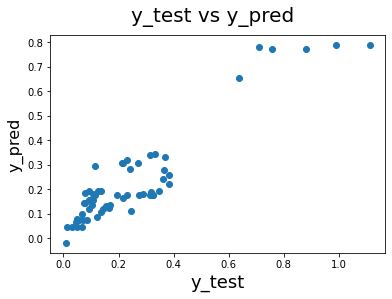

In [88]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [89]:
r2_score(y_test, y_pred)

0.8457537439014433

### RFE and Manual 

From domain knowledge, we know that with the same specification, Asian cars are cheaper than European and American cars. We also know that the Mid-range car (Upscale_Mainstream) costs more than the Mainstream car. Car segmentation is playing a role here.

In [90]:
#X_train_rfe['European'] = X_train['European']
X_train_rfe['Upscale_Mainstream'] = X_train['Upscale_Mainstream']
X_train_rfe['Asian'] = X_train['Asian']

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_rfe.drop('const', axis=1).columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [91]:
lm_rfe_7 = sm.OLS(y_train, X_train_rfe).fit()   # Running the linear model
print(lm_rfe_7.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     249.6
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           5.76e-74
Time:                        21:02:59   Log-Likelihood:                 205.34
No. Observations:                 143   AIC:                            -394.7
Df Residuals:                     135   BIC:                            -371.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.8769      0

In [92]:
# Making predictions
y_pred = lm_rfe_7.predict(X_test_new)

Text(0.5, 0, 'Errors')

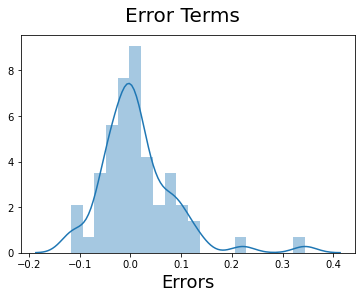

In [93]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_test - y_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

Text(0, 0.5, 'y_pred')

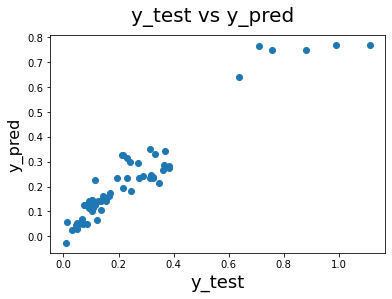

In [94]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [95]:
r2_score(y_test, y_pred)

0.8927746440498724

## Model Summary

From several models created, here is the summary:

1. Model using one predictor only 
    
    R-squared: 0.66


2. Model using RFE with non-normalized numeric variables

    R-squared: 0.89


3. Model using RFE with normalized numeric variables

    R-squared: 0.85 


4. Model using a mixture of RFE and manual variable addition with normalized numeric variables

    R-squared: 0.89

## Our Finding

We pick the highest R-squared (0.89), and both non-normalized and normalized data achieve that number.

The equations are:

**1. Non-normalized data**

    price = 17040 + 17120 Premium + 6006 Upscale_Mainstream 
            - 6782 five - 9431 four - 6211 six - 11890 three - 10030 two + 6078 rear

**2. Normalized data**

    price = 0.8769 - 0.7513 gas - 0.0969 turbo + 0.3750 Premium 
            - 0.7598 compressionratio + 0.5569 horsepower + 0.0748 Upscale_Mainstream - 0.0330 Asian

Here we are trying to summarize our finding:

1. In our analysis, the highest R-squared achieved is about 0.89.
2. The highest R-squared achieved by both non-normalized and normalized data. But this doesn't mean both are equally good, but they reveal a different perspective on how independent variables achieve dependent variables.
3. With more data, we can be more certain whether non-normalized or normalized is better.
4. In our analysis, the normalized data seems to reveal more abundant information about what attributes affecting price. Maybe this is one of the advantages of the data normalization.
5. In a more in-depth analysis, we could use more advanced metrics like RMSE to measure the model's quality.
6. Asian car is cheaper in general, so as Geely Auto, a Chinese car company, it should be in their consideration of pricing.
7. Asian cars also cost less each peak rpm and each horsepower compared to a European car. In other words, with the same specification (holding other variables constant), an Asian car should cost less.